In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import cross_validation, grid_search, linear_model, metrics,model_selection
from sklearn.metrics import confusion_matrix
from sklearn import ensemble,pipeline,preprocessing
import warnings
%pylab inline
warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных

In [75]:
X = pd.read_csv('orange_small_churn_data.train')
Y = pd.read_csv('orange_small_churn_labels.train', dtype=np.int, header=-1)

##  Вещественные переменные

In [76]:
Float_var= X.columns[:190]

## Пустые переменные

In [77]:
def get_info(X):
    '''
    X - pd.DataFrame.
    DF_var - pd.DataFrame contains info about each columns of X: count unique values and percent of missing values. 
    '''
    DF_var = pd.DataFrame(columns = ['n_values', 'NaN'])
    for var in X.columns:
        NaN_count = round(sum(X[var].isnull())*100/len(X),1)
        DF_var.at[var]=[len(X[var].dropna().unique()),NaN_count]
    return DF_var

In [78]:
DF_var = get_info(X)

In [79]:
Empty_var = DF_var[DF_var.n_values==0].index
X.drop(Empty_var, axis=1, inplace = True)

In [80]:
Float_var =list(set(Float_var) - set(Empty_var))

## Обработка вещественнх признаков 

Заменить 0.5% экстремальных значений их разумными аналогами 

In [81]:
def clear_outliers(df,Float_var,thr=1):
    """
    df -- pd.DataFrame;
    Float_var - list of float variables;
    thr - threshold of replacement rare variables, by persent;
    """
    X=df.copy()       
    for var in Float_var:
            mean = X[var].mean()
            arr_p= np.percentile(X[~X[var].isnull()][var],[thr/2, 100-thr/2]) 
            X.at[X[var]<arr_p[0],var]=mean
            X.at[X[var]>arr_p[1],var]=mean
    return X

In [82]:
X = clear_outliers(X, Float_var)

## Обработка  пропущенных значений

In [83]:
# заполение средними

In [84]:
def calculate_means(numeric_data):  
    means = [] 
    for col in numeric_data.columns:
        means.append(numeric_data[col].mean())
    return pd.Series(means, numeric_data.columns)

In [85]:
X[Float_var] = X[Float_var].fillna(calculate_means(X[Float_var])) 

In [69]:
# заполнение нулями

In [70]:
X[Float_var] = X[Float_var].fillna(0) 

После преобразования могли образоваться константные признаки, избавися от них.

In [91]:
DF_var = get_info(X)

In [92]:
Constant_var = DF_var[DF_var.n_values==1].index
X.drop(Constant_var, axis=1, inplace = True)
Float_var =list(set(Float_var) - set(Constant_var))

## Нормализация 

In [93]:
def normalization(X,Float_var):
    for var in Float_var:
        X[var]=((X[var]-X[var].mean())/float(X[var].std())).round(decimals=3)

In [94]:
normalization(X,Float_var)

In [95]:
X_scale = X[Float_var]

### Hold-out 

In [102]:
train_data, hold_out_data, train_labels, hold_out_labels = cross_validation.train_test_split(X_scale, Y, stratify = Y, test_size = 0.2)

## Построение моделей

### cv_strategy

In [103]:
cv_strategy = cross_validation.StratifiedKFold(train_labels[0], n_folds = 20)

### Случайный лес

In [104]:
RF = ensemble.RandomForestClassifier(n_estimators=150,max_depth=9,n_jobs=-1,class_weight='balanced')

In [105]:
RF = ensemble.RandomForestClassifier(n_estimators=150,max_depth=9,n_jobs=-1,class_weight='balanced')

%time predict = cross_validation.cross_val_predict(RF, train_data,train_labels, cv = cv_strategy)

print metrics.classification_report(train_labels, predict) 

Wall time: 38.4 s
             precision    recall  f1-score   support

         -1       0.95      0.75      0.84     29619
          1       0.14      0.51      0.22      2381

avg / total       0.89      0.73      0.79     32000



In [106]:
%time scoring  = cross_validation.cross_val_score(RF, train_data,train_labels[0],scoring='roc_auc', cv = cv_strategy)

print 'mean: {}, std: {}'.format(scoring.mean(), scoring.std())

Wall time: 37.2 s
mean: 0.697468127268, std: 0.0197053639881


##### Кривая обучения

In [111]:
def plot_learning_curve(model,X,Y, size = 10):

    train_sizes, train_scores, test_scores = model_selection.learning_curve(model, X, Y, scoring = 'roc_auc',\
                                            train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1, cv=cv_strategy)
    plt.figure(figsize=(size,size*0.75))
    plt.xlabel(u"Размер обучающей выборки",fontsize = size)
    plt.ylabel("AUC ROC",fontsize = size)
    plt.xticks(fontsize = size)
    plt.yticks(fontsize = size)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - 2.*train_scores_std,
                     train_scores_mean + 2.*train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - 2.*test_scores_std,
                     test_scores_mean + 2.*test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label=u"AUC на обучающей выборке")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label=u"AUC на кросс-валидации")

    plt.legend(loc="best",fontsize = size)
    plt.show()

##### Кривая precision-recall

In [112]:
def plot_precision_recall_curve(y_real, y_score,size = 10):
    
    plt.figure(figsize=(size,size*0.75))
    plt.grid()
    plt.xlabel('Recall',fontsize = size)
    plt.ylabel('Precision',fontsize = size)
    plt.xticks(fontsize = size)
    plt.yticks(fontsize = size)
    precision, recall, thresholds  = metrics.precision_recall_curve(y_real, y_score)
    
    plt.plot(recall, precision, color='r', label=u'Кривая Precision-Recall')
    
    plt.ylim([0.0, 1.1])
    plt.xlim([0.0, 1])
    plt.legend(loc="best",fontsize = size)
    plt.grid()
    plt.show()

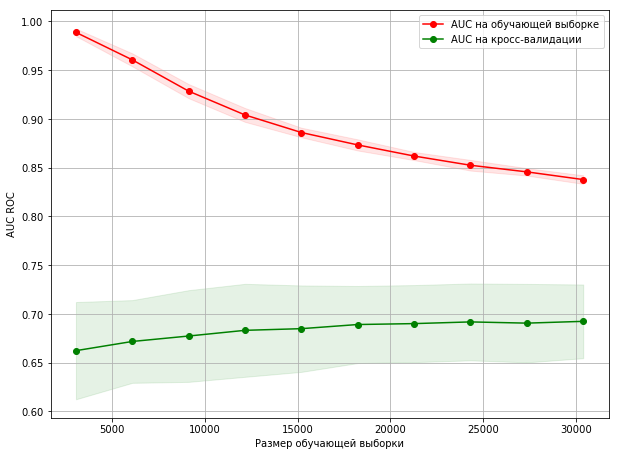

In [113]:
plot_learning_curve(RF,X_scale,Y)

In [116]:
RF.fit(train_data,train_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [117]:
def plot_precision_recall_curve(y_real, y_score,size=10):
    
    plt.figure(figsize=(size,size*0.75))
    plt.grid()
    precision, recall, thresholds  = metrics.precision_recall_curve(y_real, y_score)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    plt.plot(recall, precision, color='navy',
             label=u'Кривая Precision-Recall')
    plt.xlabel('Recall',fontsize = 25)
    plt.ylabel('Precision',fontsize = 25)
    plt.ylim([0.0, 1.1])
    plt.xlim([0.0, 1])
    plt.legend(loc="lower left",fontsize = 25)
    plt.show()

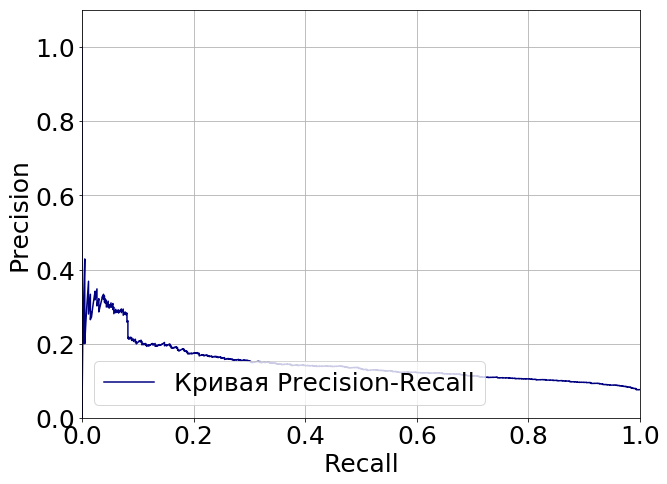

In [118]:
y_score = RF.predict_proba( hold_out_data)
plot_precision_recall_curve(hold_out_labels, y_score[:,1])

## Логистическая регрессия

In [119]:
LR = linear_model.LogisticRegression(C=1,penalty='l1', max_iter=100,n_jobs=-1, class_weight='balanced')


In [120]:
%time scoring = cross_validation.cross_val_score(LR, train_data, train_labels, scoring = 'roc_auc', cv = cv_strategy)

print ' mean: {}, std: {}'.format(scoring.mean(), scoring.std())

Wall time: 8min 7s
 mean: 0.648974330211, std: 0.0256853828035


In [121]:
%time predict = cross_validation.cross_val_predict(LR, train_data, train_labels, cv = cv_strategy)

print metrics.classification_report(train_labels, predict)

Wall time: 8min 19s
             precision    recall  f1-score   support

         -1       0.95      0.58      0.72     29619
          1       0.11      0.65      0.19      2381

avg / total       0.89      0.58      0.68     32000



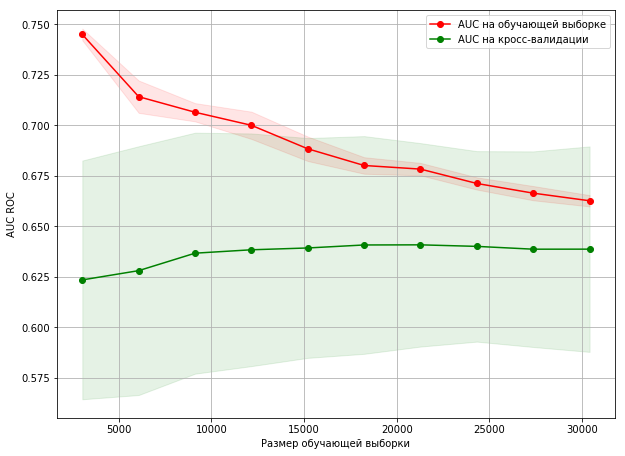

In [124]:
plot_learning_curve(LR,X_scale,Y)

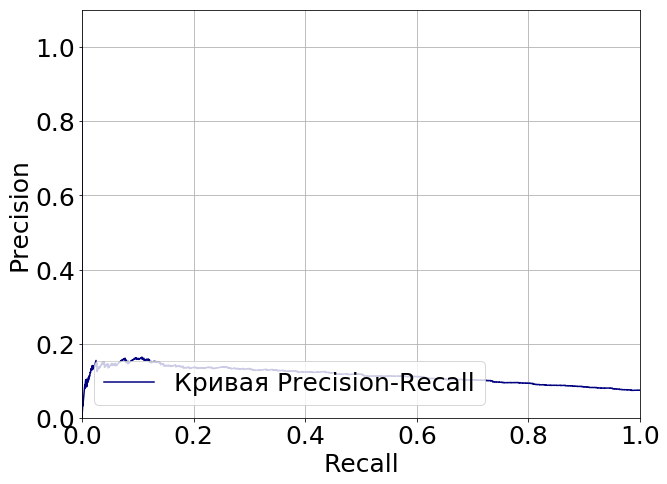

In [125]:
LR.fit(train_data,train_labels)
y_score = LR.predict_proba( hold_out_data)
plot_precision_recall_curve(hold_out_labels, y_score[:,1])

## Градиетный бустинг

In [126]:
GBC1 =  ensemble.GradientBoostingClassifier(max_depth=3,n_estimators=100,learning_rate=0.1,subsample=0.66)
GBC1.fit(train_data, train_labels)
GBC1.predict_proba(hold_out_data)

array([[ 0.9601074 ,  0.0398926 ],
       [ 0.94329285,  0.05670715],
       [ 0.91884486,  0.08115514],
       ..., 
       [ 0.97576698,  0.02423302],
       [ 0.88195954,  0.11804046],
       [ 0.96226031,  0.03773969]])

In [127]:
print metrics.roc_auc_score(hold_out_labels, GBC1.predict_proba(hold_out_data)[:,1])

0.705165031576


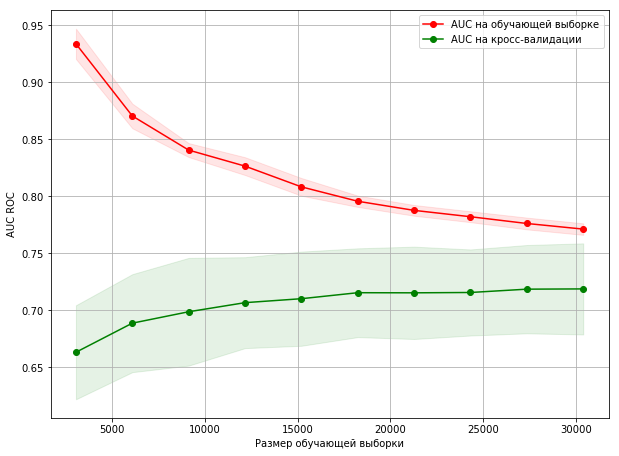

In [128]:
plot_learning_curve(GBC1 ,X_scale,Y)

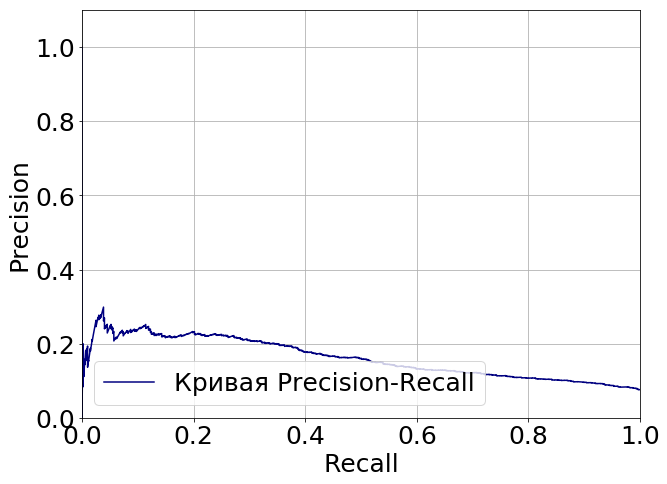

In [129]:
GBC1.fit(train_data,train_labels)
y_score = GBC1.predict_proba( hold_out_data)
plot_precision_recall_curve(hold_out_labels, y_score[:,1])